# Employee Review Sentiment Analysis with BERT

__author__ = "Fiodar Ryzhykau"
__version__ = "CS224u, Stanford, Fall 2020"

### Project Outline

**Step 1**: Project Introduction

**Step 2**: Exploratory Data Analysis and Preprocessing

**Step 3**: Training/Validation Split

**Step 4**: Loading BERT Tokenizer and Encoding the Data

**Step 5**: Setting up BERT Pretrained Model

**Step 6**: Creating Data Loaders

**Step 7**: Setting Up Optimizer and Scheduler

**Step 8**: Defining the Performance Metrics

**Step 9**: Training BERT

**Step 10**: Result Evaluation

**Step 11**: Comparing with classic model baselines

## Step 1: Project Introduction

There is still a relatively small amount of NLU research in the area of Human Social Science in the work environment. One of the main reasons is a high sensitivity of the personal information, and as a result - lack of publicly available data for analysis and experimentation.

The general definition of the “9-box" performance and potential analysis task, which is explored in this paper, maps to the text classification field, and can be characterized as a multi-dimensional sentiment analysis of employee reviews.

Conducted experiments validate the benefits of transfer-learning on a new domain with multi-class sentiment space. The main challenge in this task is a very little distinction between the close classes and sensitivity to the actual meaning of the words and phrases in the reviews. Instead of 2 (Positive|Negative) or 3 (Positive|Neutral|Negative) more commonly tested classes, this task is being focused on 9.

Results confirmed that sentiment analysis based on BERT  significantly outperforms the well-known classification methods.

Code available in github: https://github.com/fryzhykau/BERT-employee-reviews-analysis 

Models used:
* [HuggingFace models](https://huggingface.co/transformers/model_doc/bert.html)

* [Bert overview](https://characters.fandom.com/wiki/Bert_(Sesame_Street). 
For more information, the original paper can be found [here](https://arxiv.org/abs/1810.04805). 

## Step 2: Exploratory Data Analysis and Preprocessing

Dataset Has been collected from Amazon MTurk.

In [1]:
from google.colab import drive
from google.colab import auth
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import wordcloud
import os
import seaborn as sn
import matplotlib.pyplot as plt

TRAINED_MODELS_FOLDER = 'trained_models'
if not os.path.exists(TRAINED_MODELS_FOLDER):
    os.makedirs(TRAINED_MODELS_FOLDER)

STATS_FOLDER = 'stats'
if not os.path.exists(STATS_FOLDER):
    os.makedirs(STATS_FOLDER)

ANALYSIS_FOLDER = 'analysis'   
if not os.path.exists(ANALYSIS_FOLDER):
    os.makedirs(ANALYSIS_FOLDER)

DATA_FOLDER = 'drive/My Drive/Collab_Drive'

In [3]:
pd.set_option('display.max_colwidth', 2000)
df = pd.read_csv(DATA_FOLDER + f'/employee_review_mturk_dataset_13_and_test_v10.csv')
df.set_index('id', inplace=True)
df.dropna(inplace=True)

In [4]:
df.head(3)
#df.tail(10)

,person_name,nine_box_category,feedback,adjusted,reviewed
id,,,,,
1,John Doe,"Category 1: 'Risk' (Low performance, Low potential)","John has not progressed in his position. He is continuously late, leaves early, and takes many breaks throughout the day. He calls out at least every other week and it's always on Fridays. His performance has significantly declined. My suggestion is he is not suitable for this position.",False,True
2,John Doe,"Category 1: 'Risk' (Low performance, Low potential)","John has consistently disappointed me this quarter with his shoddy work product. I asked him for a report and gave him a lenient two-week deadline, but he blew past that deadline without even informing me. When he finally turned the report in, it was three weeks late and riddled with typos. He did not seem interested in any of the comments that I made on that report, even though I made them for his benefit so he would understand what a high-quality report is supposed to look like.",False,True
3,John Doe,"Category 1: 'Risk' (Low performance, Low potential)","John turned in subpar work product all quarter. When I asked him to make revisions, he repeatedly failed to implement the corrections that I had requested. He also seemed confused and lost whenever we had discussions about the reports and the numbers in the data. He was not interested in learning more when I gave him opportunities to participate in trainings. He seems to have already reached his full potential here, which is disappointing given the quality of work I've seen from him.",False,True


In [5]:
possible_labels = df.nine_box_category.unique()
possible_labels = np.sort(possible_labels)

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

label_dict_inverse = {v: k for k, v in label_dict.items()}

pp_map = {}
pp_map[0] = [0,0]
pp_map[1] = [1,0]
pp_map[2] = [2,0]
pp_map[3] = [0,1]
pp_map[4] = [1,1]
pp_map[5] = [2,1]
pp_map[6] = [0,2]
pp_map[7] = [1,2]
pp_map[8] = [2,2]

In [6]:
import nltk
from nltk import tokenize

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
pass

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
print(f'\nInitial dataset size: {len(df.index)}')

df_upd = df.copy()
df_upd['label'] = df_upd.nine_box_category.replace(label_dict)
df_upd['feedback'] = df_upd.feedback.replace('\\r',' ', regex=True)
df_upd['feedback_len'] = df_upd.feedback.str.len()
df_upd['num_of_sent'] = df_upd.feedback.apply(lambda s: len(tokenize.sent_tokenize(s)))
df_upd['performance_class'] = df_upd.label.apply(lambda l: pp_map[l][0])
df_upd['potential_class'] = df_upd.label.apply(lambda l: pp_map[l][1])

feedback_len_stats = df_upd['feedback_len'].describe(percentiles=[.05,.10,.25,.50,.75,.85,.90,.95])
print(f'\nFeedback len stats: \n{feedback_len_stats}')

num_of_sent_stats = df_upd['num_of_sent'].describe(percentiles=[.05,.10,.25,.50,.75,.85,.90,.95])
print(f'\nFeedback sentence num stats: \n{num_of_sent_stats}')

df_upd = df_upd.loc[(df_upd['feedback_len'] > 150) & (df_upd['feedback_len'] < 600)]
df_upd = df_upd.loc[df_upd['num_of_sent'] > 1]
df_upd = df_upd.loc[~df_upd['feedback'].str.contains('category') & ~df_upd['feedback'].str.contains('Category')]

print(f'\nSize after filtering: {len(df_upd.index)}')

df = df_upd.sort_values(by=['label']).copy()
#df.tail()


Initial dataset size: 878

Feedback len stats: 
count    878.000000
mean     335.930524
std      133.783240
min       61.000000
5%       155.000000
10%      181.700000
25%      238.250000
50%      317.000000
75%      408.750000
85%      482.000000
90%      523.300000
95%      580.150000
max      971.000000
Name: feedback_len, dtype: float64

Feedback sentence num stats: 
count    878.000000
mean       4.146925
std        1.026472
min        1.000000
5%         2.000000
10%        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
85%        5.000000
90%        5.000000
95%        6.000000
max       11.000000
Name: num_of_sent, dtype: float64

Size after filtering: 772


In [8]:
import re
from nltk.corpus import stopwords

'''
Utils leveraged from : 
https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d
https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/natural_language_processing/example_text_classification.ipynb
Preprocess a string.
:parameter
    :param txt: string - name of column containing text
    :param lst_regex: list - list of regex to remove
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(txt, lst_regex=None, lst_stopwords=None, flg_stemm=False, flg_lemm=True):
    ## regex (in case, before processing)
    if lst_regex is not None: 
        for regex in lst_regex:
            txt = re.sub(regex, '', txt)
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    txt = re.sub(r'[^\w\s]', '', str(txt).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_txt = txt.split()

    ## remove Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
                
    ## Lemmatization (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]

    ## remove leftover Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
            
    ## back to string from list
    txt = " ".join(lst_txt)
    return txt

'''
Adds a column of preprocessed text.
:parameter
    :param dtf: dataframe - dtf with a text column
    :param column: string - name of column containing text
:return
    dtf: input dataframe with two new columns: column+"_clean" and "check"
'''
def add_preprocessed_text(dtf, column, lst_regex=None, lst_stopwords=None, flg_stemm=False, flg_lemm=True, remove_na=True):
    ## apply preprocess
    dtf = dtf[ pd.notnull(dtf[column]) ]
    dtf[column+"_clean"] = dtf[column].apply(lambda x: utils_preprocess_text(x, lst_regex, lst_stopwords, flg_stemm, flg_lemm))
    
    ## residuals
    dtf["check"] = dtf[column+"_clean"].apply(lambda x: len(x))
    if dtf["check"].min() == 0:
        print("--- found NAs ---")
        print(dtf[[column,column+"_clean"]][dtf["check"]==0].head())
        if remove_na is True:
            dtf = dtf[dtf["check"]>0] 
            
    return dtf.drop("check", axis=1)

'''
Creates a list of stopwords.
:parameter
    :param lst_langs: list - ["english", "italian"]
    :param lst_add_words: list - list of new stopwords to add
    :param lst_keep_words: list - list words to keep (exclude from stopwords)
:return
    stop_words: list of stop words
'''      
def create_stopwords(lst_langs=["english"], lst_add_words=[], lst_remove_words=[]):
    lst_stopwords = set()
    for lang in lst_langs:
        lst_stopwords = lst_stopwords.union( set(nltk.corpus.stopwords.words(lang)) )
    lst_stopwords = lst_stopwords.union(lst_add_words)
    lst_stopwords = list(set(lst_stopwords) - set(lst_remove_words))
    return sorted(list(set(lst_stopwords)))

lst_stopwords = [] # works best so far without stopwords

#lst_stopwords = create_stopwords(["english"], 
#                                 lst_add_words=[],
#                                 lst_remove_words=[ 'is', 'isn', "isn't",'needn', "needn't", 'no', 'nor', 'not'])

use_stemming = False
use_lemming = True

print("--- stopwords ---")
print(lst_stopwords)

print("--- original feedback ---")
feedback_data = df["feedback"].iloc[0]

print(feedback_data)

print("--- cleaning ---")
print(utils_preprocess_text(feedback_data, lst_regex=None, 
                      lst_stopwords=None, flg_stemm=use_stemming, flg_lemm=use_lemming))

print("--- tokenization ---")
print(feedback_data.split())

print("--- remove stopwords ---")
print(utils_preprocess_text(feedback_data, lst_regex=None, 
                      lst_stopwords=lst_stopwords, 
                      flg_stemm=use_stemming, flg_lemm=use_lemming))

print("--- stemming ---")
print(utils_preprocess_text(feedback_data, lst_regex=None, 
                      lst_stopwords=lst_stopwords, 
                      flg_stemm=True, flg_lemm=use_lemming))

print("--- lemmatisation ---")
print(utils_preprocess_text(feedback_data, lst_regex=None, 
                      lst_stopwords=lst_stopwords, 
                      flg_stemm=use_stemming, flg_lemm=use_lemming))

df = add_preprocessed_text(df, "feedback",
                           lst_regex=None,
                           lst_stopwords=lst_stopwords,
                           flg_stemm=use_stemming,
                           flg_lemm=use_lemming)

print("\n--- feedback cleanup result ---")
print(df["feedback"].iloc[0], " --> ")
print(df["feedback_clean"].iloc[0])

--- stopwords ---
[]
--- original feedback ---
John has not progressed in his position. He is continuously late, leaves early, and takes many breaks throughout the day. He calls out at least every other week and it's always on Fridays. His performance has significantly declined. My suggestion is he is not suitable for this position.
--- cleaning ---
john ha not progressed in his position he is continuously late leaf early and take many break throughout the day he call out at least every other week and it always on friday his performance ha significantly declined my suggestion is he is not suitable for this position
--- tokenization ---
['John', 'has', 'not', 'progressed', 'in', 'his', 'position.', 'He', 'is', 'continuously', 'late,', 'leaves', 'early,', 'and', 'takes', 'many', 'breaks', 'throughout', 'the', 'day.', 'He', 'calls', 'out', 'at', 'least', 'every', 'other', 'week', 'and', "it's", 'always', 'on', 'Fridays.', 'His', 'performance', 'has', 'significantly', 'declined.', 'My', 's

# 0:


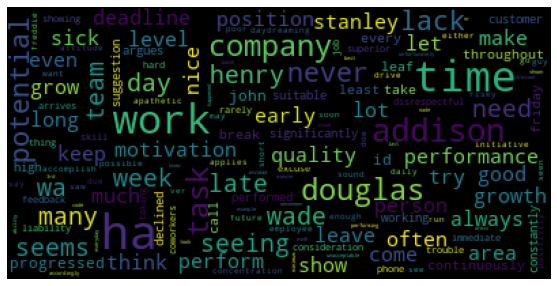

# 1:


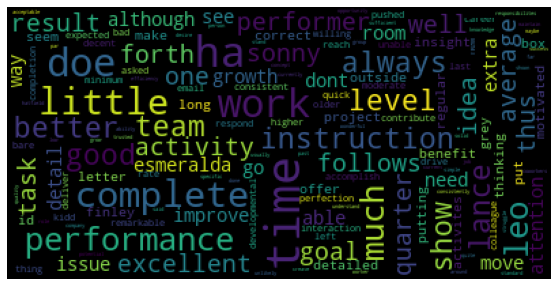

# 2:


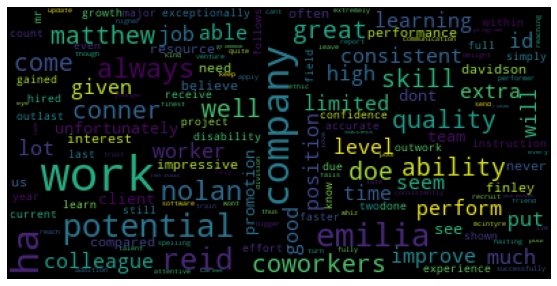

# 3:


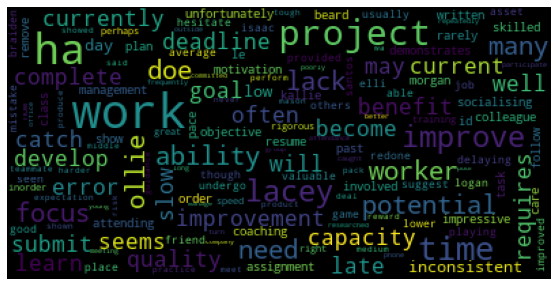

# 4:


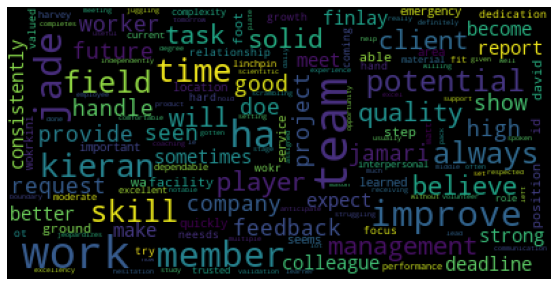

# 5:


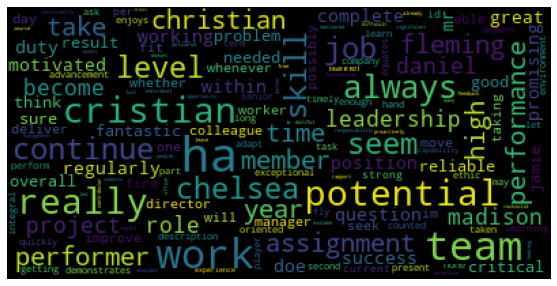

# 6:


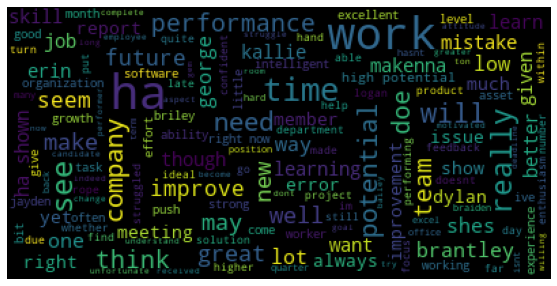

# 7:


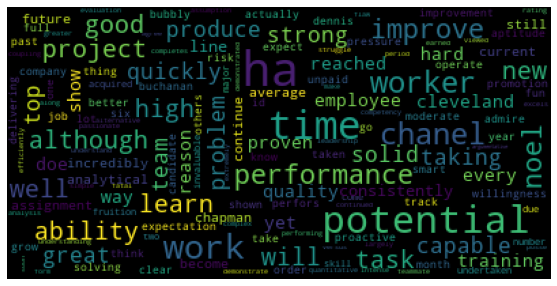

# 8:


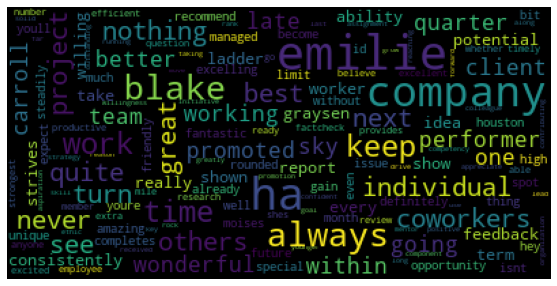

In [9]:
def plot_wordcloud(corpus, description="default", max_words=150, max_font_size=35, figsize=(10,10)):
    wc = wordcloud.WordCloud(background_color='black', max_words=max_words, max_font_size=max_font_size)
    wc = wc.generate(str(corpus)) #if type(corpus) is not dict else wc.generate_from_frequencies(corpus)     
    fig = plt.figure(num=1, figsize=figsize)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.savefig(STATS_FOLDER + f'/{description}_wordcloud.png')
    plt.show()

for label in df.label.unique():
    print("# {}:".format(label))
    plot_wordcloud(corpus=df[df["label"]==label]["feedback_clean"], description=label, max_words=150, max_font_size=35, figsize=(10,5))

In [10]:
#bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
res = df_upd['feedback_len'].value_counts(bins=10, sort=False)
print(f'\nDistribution by len in filtered: \n{res}')


Distribution by len in filtered: 
(150.551, 195.8]     63
(195.8, 240.6]      101
(240.6, 285.4]      126
(285.4, 330.2]      124
(330.2, 375.0]      103
(375.0, 419.8]       87
(419.8, 464.6]       49
(464.6, 509.4]       54
(509.4, 554.2]       37
(554.2, 599.0]       28
Name: feedback_len, dtype: int64


In [11]:
df.performance_class.value_counts().sort_index()

0    244
1    265
2    263
Name: performance_class, dtype: int64

In [12]:
df.potential_class.value_counts().sort_index()

0    281
1    276
2    215
Name: potential_class, dtype: int64

In [13]:
df.nine_box_category.value_counts()

Category 1: 'Risk' (Low performance, Low potential)                        114
Category 5: 'Core Player' (Moderate performance, Moderate potential)       104
Category 9: 'Star' (High performance, High potential)                      103
Category 4: 'Inconsistent Player' (Low performance, Moderate potential)     94
Category 2: 'Average performer' (Moderate performance, Low potential)       85
Category 3: 'Solid Performer' (High performance, Low potential)             82
Category 6: 'High Performer' (High performance, Moderate potential)         78
Category 8: 'High Potential' (Moderate performance, High potential)         76
Category 7: 'Potential Gem' (Low performance, High potential)               36
Name: nine_box_category, dtype: int64

## Step 3: Training/Validation Split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['nine_box_category', 'label', 'data_type']).count()
pass

# Using same datasets for final model testing & evaluation

train_df = pd.read_csv(DATA_FOLDER + f'/v26-bu/train_set.csv')
train_df.set_index('id', inplace=True)

#train_df = df[df.data_type=='train']

val_df = pd.read_csv(DATA_FOLDER + f'/v26-bu/validation_set.csv')
val_df.set_index('id', inplace=True)

#val_df = df[df.data_type=='val']

## Step 4: Loading BERT Tokenizer and Encoding the Data

In [15]:
!pip install transformers
pass

In [16]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [17]:
#bert_type = 'bert-base-uncased'
#bert_type = 'bert-base-cased'
#bert_type = 'bert-large-uncased'
bert_type = 'bert-large-cased'

if "uncased" not in bert_type: 
    convert_to_lowercase=False
else:
    convert_to_lowercase=True

tokenizer = BertTokenizer.from_pretrained(bert_type, 
                                          do_lower_case=convert_to_lowercase)

In [18]:
max_sequence_size=512

encoded_data_train = tokenizer.batch_encode_plus(
    train_df.feedback.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=max_sequence_size, 
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df.feedback.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=max_sequence_size, 
    return_tensors='pt',
    truncation=True
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.label.values)

In [19]:
train_df.to_csv('train_set.csv')
val_df.to_csv('validation_set.csv')

In [20]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [21]:
print(f'Dataset size full     : {len(dataset_train) + len(dataset_val)}')
print(f'Dataset for training  : {len(dataset_train)}')
print(f'Dataset for validation: {len(dataset_val)}')

Dataset size full     : 772
Dataset for training  : 656
Dataset for validation: 116


## Step 5: Setting up BERT Pretrained Model

In [22]:
from transformers import BertForSequenceClassification

In [23]:
print(f'Num of labels:{len(label_dict)}')
model = BertForSequenceClassification.from_pretrained(bert_type,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



Num of labels:9


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

## Step 6: Creating Data Loaders

In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [25]:
if "large" not in bert_type: 
    batch_size = 16
else:
    batch_size = 4

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

## Step 7: Setting Up Optimiser and Scheduler

In [26]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [27]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [28]:
if "large" not in bert_type: 
    epochs = 30
else:
    epochs = 15

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Step 8: Defining the Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [29]:
from sklearn.metrics import f1_score

In [30]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


In [31]:
def get_dataset_id_label_map(input_df):
    labels = input_df.label.unique()
    result_map = dict()
    for label in labels:
        rows_with_labels = input_df.loc[input_df['label'] == label]
        ids = rows_with_labels.index
        result_map[label] = ids.copy()
    return result_map

In [32]:
def calculate_stats_per_class(preds, labels, input_df=pd.DataFrame()):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    total_correct = 0
    overall_gold = 0
    id_map = get_dataset_id_label_map(input_df)   
    output_df  = input_df.copy()    
    all_predictions = np.array([])
    

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]  
        print(f'Class: {label_dict_inverse[label]}')

        all_predictions = np.concatenate((all_predictions, y_preds), axis=0)

        correct = len(y_preds[y_preds==label])
        total_correct += correct
        num_of_gold = len(y_true)
        overall_gold += num_of_gold

        print(f'Predictions: {y_preds}')
        print(f'Gold Values: {y_true}')
        print(f'Ids: {id_map[label]}')
       
        print(f'Accuracy: {correct}/{num_of_gold}  ' + '{:.2f}\n'.format(correct/num_of_gold))  

    print(f'AVG Accuracy: {total_correct}/{overall_gold}  '+ '{:.2f}\n'.format(total_correct/overall_gold))

    output_df['ml_prediction_label'] = pd.Series(all_predictions, index=output_df.index)
    output_df['ml_category'] = output_df.ml_prediction_label.apply(lambda l: label_dict_inverse[l])
    output_df['ml_performance_class'] = output_df.ml_prediction_label.apply(lambda l: pp_map[l][0])
    output_df['ml_potential_class'] = output_df.ml_prediction_label.apply(lambda l: pp_map[l][1])
    output_df['ml_match'] = output_df.apply(lambda row: row.label == row.ml_prediction_label, axis=1)
    output_df['performance_match'] = output_df.apply(lambda row: row.performance_class == row.ml_performance_class, axis=1)
    output_df['potential_match'] = output_df.apply(lambda row: row.potential_class == row.ml_potential_class, axis=1)

    print('Performance Accuracy: {:0.2f}\n'.format(output_df["performance_match"].mean()))
    print('Potential Accuracy: {:0.2f}\n'.format(output_df["potential_match"].mean()))
    
    return output_df

## Step 9: Training BERT

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [33]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [34]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [35]:
def evaluate(dataloader_values, target_model):

    target_model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_values:
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = target_model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_values) 

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [36]:
epoch_list = []
train_loss = []
validation_loss = []
f1_scores_weighted = []
last_saved_epoch = 0

if "large" not in bert_type: 
    min_epoch_to_save = 15
else:
    min_epoch_to_save = 0

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        #print(f'loss {loss}')
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)             
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation, model)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

    epoch_list.append(epoch)
    train_loss.append(loss_train_avg)
    validation_loss.append(val_loss)
    f1_scores_weighted.append(val_f1)

    if (epoch > min_epoch_to_save):    
        torch.save(model.state_dict(), TRAINED_MODELS_FOLDER + f'/{bert_type}_epoch_{epoch}.model')
        last_saved_epoch = epoch

    df_learning_curve = pd.DataFrame({'epoch': epoch_list,
                  'train_loss_avg': train_loss,
                  'validation_loss': validation_loss,
                  'val_f1_weighted': f1_scores_weighted})

    lc_file_name = STATS_FOLDER + f'/{bert_type}_learning_curve_{epoch}.csv'
    df_learning_curve.to_csv(lc_file_name, index=False)



Epoch 1
Training loss: 2.1182147395320055
Validation loss: 1.7963989788088306
F1 Score (Weighted): 0.2543907907751721



Epoch 2
Training loss: 1.5059750221851396
Validation loss: 1.4991965889930725
F1 Score (Weighted): 0.45582510004713533



Epoch 3
Training loss: 0.9894036796034836
Validation loss: 1.3280235744755844
F1 Score (Weighted): 0.5450921815476806



Epoch 4
Training loss: 0.5464163011212538
Validation loss: 1.1437899403530976
F1 Score (Weighted): 0.6128566133884528



Epoch 5
Training loss: 0.2531348069357436
Validation loss: 1.1740753511930335
F1 Score (Weighted): 0.6394915053535885



Epoch 6
Training loss: 0.0993722888567235
Validation loss: 1.3592824213335226
F1 Score (Weighted): 0.6624745648925293



Epoch 7
Training loss: 0.044404399156763516
Validation loss: 1.5216307685036083
F1 Score (Weighted): 0.635741912615689



Epoch 8
Training loss: 0.021907665342285592
Validation loss: 1.657403384335339
F1 Score (Weighted): 0.6250814344467595



Epoch 9
Training loss: 0.007619266403220003
Validation loss: 1.8617588816419373
F1 Score (Weighted): 0.6188076123568174



Epoch 10
Training loss: 0.0031139218538045518
Validation loss: 1.7552973036895152
F1 Score (Weighted): 0.636738544627962



Epoch 11
Training loss: 0.0020125115065971707
Validation loss: 1.7781438667002005
F1 Score (Weighted): 0.6445278827175378



Epoch 12
Training loss: 0.0017815758449326428
Validation loss: 1.839755908014044
F1 Score (Weighted): 0.637005890712005



Epoch 13
Training loss: 0.0015646304495820049
Validation loss: 1.8359916457898338
F1 Score (Weighted): 0.645177550931262



Epoch 14
Training loss: 0.0015006309904714637
Validation loss: 1.8562069101829146
F1 Score (Weighted): 0.6445278827175378



Epoch 15
Training loss: 0.00142646433534271
Validation loss: 1.858593348042381
F1 Score (Weighted): 0.6445278827175378



In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter

lc_file_name = STATS_FOLDER + '/' + bert_type + f'_learning_curve_{last_saved_epoch}.csv';

df_learning_curve = pd.read_csv(lc_file_name)

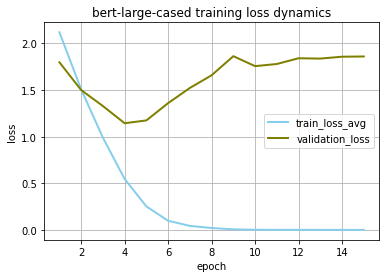

In [38]:
# Training loss plot

plt.plot( 'epoch', 'train_loss_avg', data=df_learning_curve,   color='skyblue', linewidth=2, label="train_loss_avg")
plt.plot( 'epoch', 'validation_loss', data=df_learning_curve,  color='olive', linewidth=2, label="validation_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title(f'{bert_type} training loss dynamics') 
plt.grid(True) 
#plt.ylim(0, 2.5)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.savefig(STATS_FOLDER + f'/{bert_type}_training_loss.png')
plt.show() 

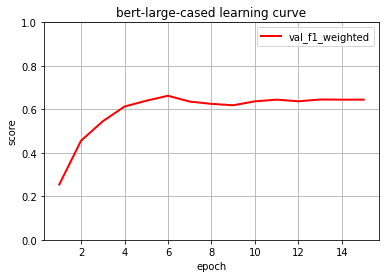

In [39]:
# Training Evaluation Dynamics plot
plt.plot( 'epoch', 'val_f1_weighted', data=df_learning_curve,  color='red', linewidth=2,  label="val_f1_weighted")
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()
plt.title(f'{bert_type} learning curve') 
plt.grid(True) 
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.ylim(0, 1)
plt.savefig(STATS_FOLDER + f'/{bert_type}_learning_curve.png')
plt.show() 

## Step 10: Result Evaluation

In [40]:
#Preparing Clean and unseen Test Set
test_df = pd.read_csv(DATA_FOLDER + f'/employee_review_mturk_dataset_test_batch_2_v6.csv')

test_df.set_index('id', inplace=True)
test_df.dropna(inplace=True)

test_df['feedback'] = test_df.feedback.replace('\\r',' ', regex=True)
test_df['label'] = test_df.nine_box_category.replace(label_dict)
test_df['performance_class'] = test_df.label.apply(lambda l: pp_map[l][0])
test_df['potential_class'] = test_df.label.apply(lambda l: pp_map[l][1])
test_df = test_df.sort_values(by=['label'])

test_df = add_preprocessed_text(test_df,
                                "feedback",
                                lst_regex=None,
                                lst_stopwords=lst_stopwords,
                                flg_stemm=use_stemming,
                                flg_lemm=use_lemming)

test_df.to_csv(f'test_set.csv')
#test_df.head()


In [41]:
print(f'Test Set size: {len(test_df)}')
print(f'Num of Test Classes:\n{test_df.nine_box_category.value_counts()}')

max_sequence_size=512

encoded_data_test = tokenizer.batch_encode_plus(
    test_df.feedback.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=max_sequence_size, 
    return_tensors='pt',
    truncation=True
)


input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df.label.values)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

Test Set size: 225
Num of Test Classes:
Category 2: 'Average performer' (Moderate performance, Low potential)      25
Category 3: 'Solid Performer' (High performance, Low potential)            25
Category 1: 'Risk' (Low performance, Low potential)                        25
Category 5: 'Core Player' (Moderate performance, Moderate potential)       25
Category 9: 'Star' (High performance, High potential)                      25
Category 4: 'Inconsistent Player' (Low performance, Moderate potential)    25
Category 8: 'High Potential' (Moderate performance, High potential)        25
Category 6: 'High Performer' (High performance, Moderate potential)        25
Category 7: 'Potential Gem' (Low performance, High potential)              25
Name: nine_box_category, dtype: int64


In [147]:
#print(f'Num of classes {len(label_dict)}')
eval_model = BertForSequenceClassification.from_pretrained(bert_type,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

eval_model.to(device)
pass

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

In [148]:
eval_model_path = TRAINED_MODELS_FOLDER + f'/{bert_type}_epoch_15.model'
#eval_model_path = TRAINED_MODELS_FOLDER + f'/{bert_type}_epoch_{last_saved_epoch}.model'
#eval_model_path = TRAINED_MODELS_FOLDER + f'/{bert_type}_epoch_{epochs}.model'
eval_model.load_state_dict(torch.load(eval_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [149]:
_, val_predictions, true_val_vals = evaluate(dataloader_validation, eval_model)
output_val_df = calculate_stats_per_class(val_predictions, true_val_vals, val_df)
output_val_df.to_csv(ANALYSIS_FOLDER + f'/{bert_type}_validation_set_analysis.csv')

Class: Category 1: 'Risk' (Low performance, Low potential)
Predictions: [0 3 0 0 0 0 0 0 0 3 3 0 1 0 0 0 0]
Gold Values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ids: Int64Index([10046, 10002, 10001,    86,    84,    78, 20046, 10223, 10209,
            10206, 10170,    72,   416,    23,    34,    48,    49],
           dtype='int64', name='id')
Accuracy: 13/17  0.76

Class: Category 2: 'Average performer' (Moderate performance, Low potential)
Predictions: [1 1 2 4 2 4 1 1 1 1 1 1 2]
Gold Values: [1 1 1 1 1 1 1 1 1 1 1 1 1]
Ids: Int64Index([174, 169, 10175, 20008, 10211, 10114, 10060, 92, 128, 127, 129,
            133, 130],
           dtype='int64', name='id')
Accuracy: 8/13  0.62

Class: Category 3: 'Solid Performer' (High performance, Low potential)
Predictions: [2 8 5 2 5 2 2 2 2 2 8 8]
Gold Values: [2 2 2 2 2 2 2 2 2 2 2 2]
Ids: Int64Index([10096, 10179, 10178, 10133, 10057, 236, 194, 188, 210, 228, 227,
            226],
           dtype='int64', name='id')
Accuracy: 7/12  0.58

Clas

In [150]:
_, test_predictions, true_test_vals = evaluate(dataloader_test, eval_model)
output_test_df = calculate_stats_per_class(test_predictions, true_test_vals, test_df)
output_test_df.to_csv(ANALYSIS_FOLDER + f'/{bert_type}_test_set_analysis.csv')


Class: Category 1: 'Risk' (Low performance, Low potential)
Predictions: [3 0 0 0 3 0 0 0 1 3 0 0 0 0 0 1 3 3 0 3 0 1 0 0 0]
Gold Values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ids: Int64Index([20051, 20214, 20213, 20212, 20186, 20173, 20172, 20170, 20141,
            20133, 20130, 20129, 20171, 20127, 20128, 20058, 20059, 20060,
            20085, 20057, 20088, 20099, 20100, 20126, 20087],
           dtype='int64', name='id')
Accuracy: 16/25  0.64

Class: Category 2: 'Average performer' (Moderate performance, Low potential)
Predictions: [1 4 1 2 1 6 1 4 6 5 1 3 5 1 1 3 4 5 1 5 1 3 2 2 3]
Gold Values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Ids: Int64Index([20149, 20174, 20175, 20179, 20216, 20227, 20219, 20231, 20232,
            20053, 20217, 20135, 20075, 20132, 20134, 20016, 20020, 20050,
            20065, 20015, 20091, 20093, 20094, 20096, 20114],
           dtype='int64', name='id')
Accuracy: 9/25  0.36

Class: Category 3: 'Solid Performer' (High performa

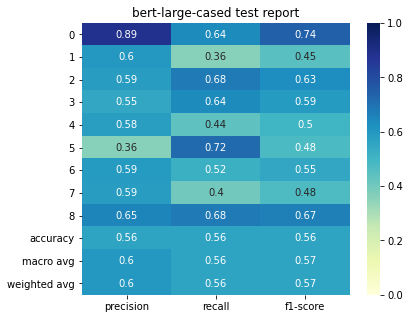

In [183]:
from sklearn.metrics import classification_report

bert_preds_flat = np.argmax(test_predictions, axis=1).flatten()
bert_test_report = classification_report(true_test_vals.flatten(), bert_preds_flat, output_dict=True)
bert_test_report_df = pd.DataFrame(bert_test_report)
bert_test_report_df.to_csv(STATS_FOLDER + f'/{bert_type}_test_stats.csv')
fig, ax = plt.subplots(figsize=(6,5))
plt.title(f'{bert_type} test report') 
bert_report_plot = sn.heatmap(bert_test_report_df.iloc[:-1, :].T, annot=True,cmap="YlGnBu", vmin=0, vmax=1, ax=ax)
bert_report_plot.get_figure().savefig(STATS_FOLDER + f'/{bert_type}_metrics.png')  

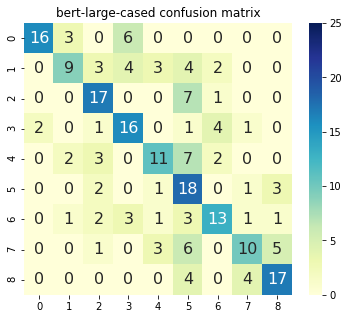

In [152]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

def confusion_matrix_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    unique_labels = np.unique(labels_flat)
    return confusion_matrix(labels_flat, preds_flat, labels=unique_labels)


cm = confusion_matrix_func(test_predictions, true_test_vals)

fig, ax = plt.subplots(figsize=(6,5))
plt.title(f'{bert_type} confusion matrix') 
cm_plot = sn.heatmap(cm, annot=True, annot_kws={"size": 16},cmap="YlGnBu", vmin=0, vmax=25, ax=ax)
cm_plot.get_figure().savefig(STATS_FOLDER + f'/{bert_type}_confusion_matrix.png')    

## Step 11: Comparing with classic model baselines

In [153]:
import time
import seaborn as sn
from sklearn import svm
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def run_classifier_experiment(input_train_vectors, train_labels, classifier = svm.SVC(kernel='linear')):
    t0 = time.time()
    classifier.fit(input_train_vectors, train_labels)
    t1 = time.time()
    time_linear_train = t1-t0
    print("Training time: %fs" % (time_linear_train))
    return classifier

def run_classifier_test(classifier, input_val_vectors, val_labels, description="default_experiment"):
    t3 = time.time()
    prediction = classifier.predict(input_val_vectors)
    t2 = time.time()  
    time_linear_predict = t2-t3
    print("Prediction time: %fs" % (time_linear_predict))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    svm_val_report = classification_report(val_labels, prediction, output_dict=True)

    weighted_avg_f1 = svm_val_report['weighted avg']['f1-score']
   
    test_plot = sn.heatmap(pd.DataFrame(svm_val_report).iloc[:-1, :].T, annot=True,cmap="YlGnBu", ax=ax[0], vmin=0, vmax=1)
    #test_plot.get_figure().savefig(STATS_FOLDER + f'/{description}.png')  

    unique_labels = np.unique(val_labels)
    cm_prediction = confusion_matrix(val_labels, prediction, labels=unique_labels)
    cm_plot = sn.heatmap(cm_prediction, annot=True, annot_kws={"size": 16},cmap="YlGnBu", ax=ax[1], vmin=0, vmax=25)
    #cm_plot.get_figure().savefig(STATS_FOLDER + f'/{description}_cm.png')
    fig.suptitle(description, fontsize=12)
    fig.show()

    fig.savefig(STATS_FOLDER + f'/{description}_stats.png')

    return prediction, val_labels, weighted_avg_f1

def validate_classic_model(model_description, classifier, train_vectors, train_labels, test_vectors, test_labels, model_results_df):
    classic_model = run_classifier_experiment(train_vectors, train_labels, classifier = classifier)
    test_preds, test_labels, test_weighted_avg_f1 = run_classifier_test(classic_model, test_vectors, test_labels, description=model_description)
    model_results_df.loc[len(model_results_df)] = [model_description, test_weighted_avg_f1]

In [154]:
# Create feature vectors
tfidf_vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

tfidf_train_vectors = tfidf_vectorizer.fit_transform(train_df.feedback)
tfidf_val_vectors = tfidf_vectorizer.transform(val_df.feedback)
tfidf_test_vectors = tfidf_vectorizer.transform(test_df.feedback)

tfidf_train_vectors_clean = tfidf_vectorizer.fit_transform(train_df.feedback_clean)
tfidf_val_vectors_clean = tfidf_vectorizer.transform(val_df.feedback_clean)
tfidf_test_vectors_clean = tfidf_vectorizer.transform(test_df.feedback_clean)

count_vectorizer = CountVectorizer()
count_train_vectors = count_vectorizer.fit_transform(train_df.feedback)
count_val_vectors = count_vectorizer.transform(val_df.feedback)
count_test_vectors = count_vectorizer.transform(test_df.feedback)

count_train_vectors_clean = count_vectorizer.fit_transform(train_df.feedback_clean)
count_val_vectors_clean = count_vectorizer.transform(val_df.feedback_clean)
count_test_vectors_clean = count_vectorizer.transform(test_df.feedback_clean)

ml_train_labels = train_df.label
ml_test_tfidf_vectors = tfidf_test_vectors
ml_test_count_vectors = count_test_vectors
ml_test_labels = test_df.label

In [155]:
classic_model_results_df = pd.DataFrame(columns=['model_configuration','weighted_avg_f1'])

Training time: 0.003442s
Prediction time: 0.000389s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


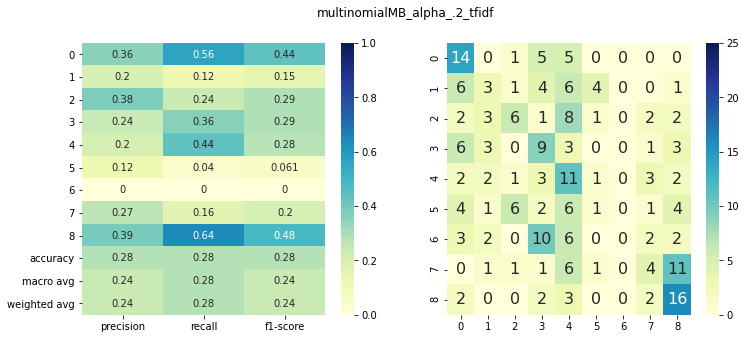

In [156]:
validate_classic_model(
    model_description = "multinomialMB_alpha_.2_tfidf",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.004088s
Prediction time: 0.000830s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


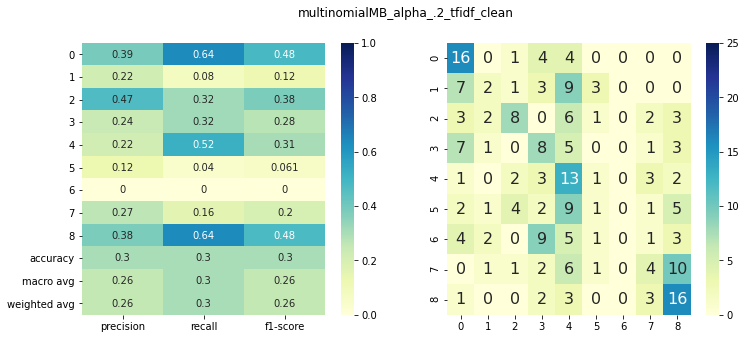

In [157]:
validate_classic_model(
    model_description = "multinomialMB_alpha_.2_tfidf_clean",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.004415s
Prediction time: 0.000454s


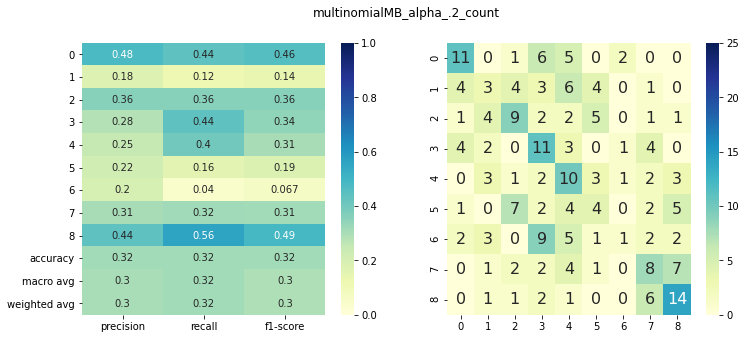

In [158]:
validate_classic_model(
    model_description = "multinomialMB_alpha_.2_count",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.005498s
Prediction time: 0.000953s


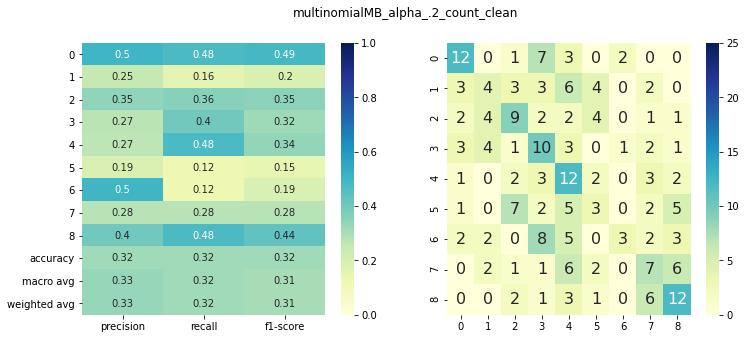

In [159]:
validate_classic_model(
    model_description = "multinomialMB_alpha_.2_count_clean",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.291899s
Prediction time: 0.050589s


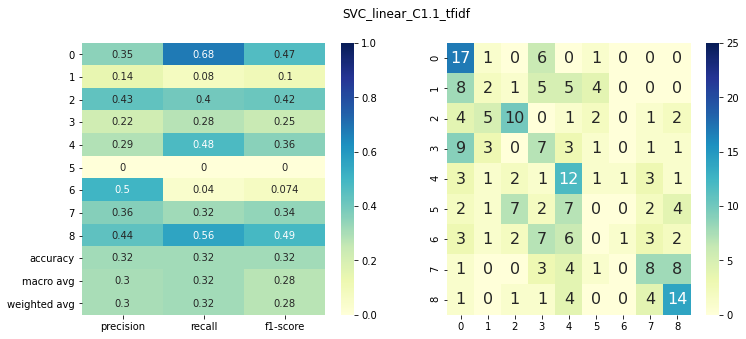

In [160]:
validate_classic_model(
    model_description = "SVC_linear_C1.1_tfidf",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.284203s
Prediction time: 0.052865s


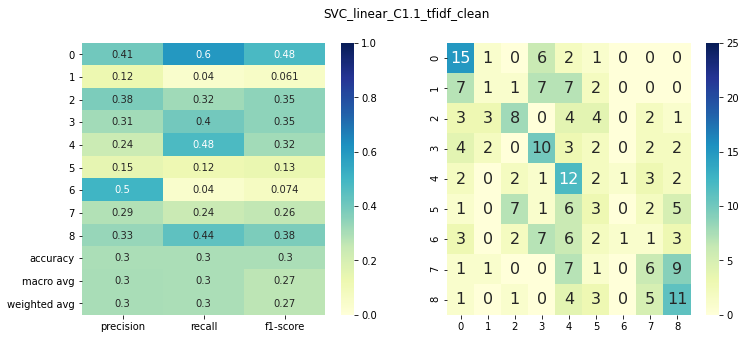

In [161]:
validate_classic_model(
    model_description = "SVC_linear_C1.1_tfidf_clean",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.360241s
Prediction time: 0.061104s


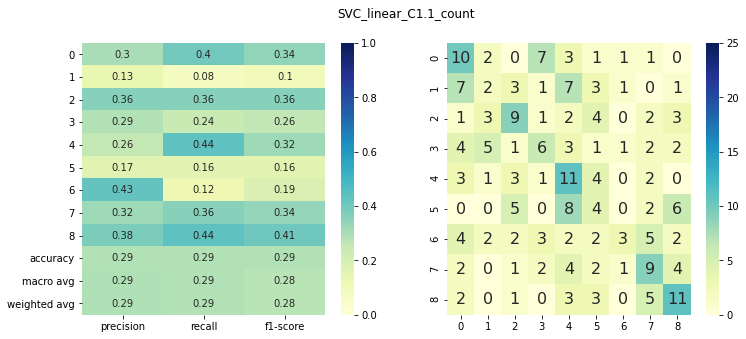

In [162]:
validate_classic_model(
    model_description = "SVC_linear_C1.1_count",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.353079s
Prediction time: 0.061684s


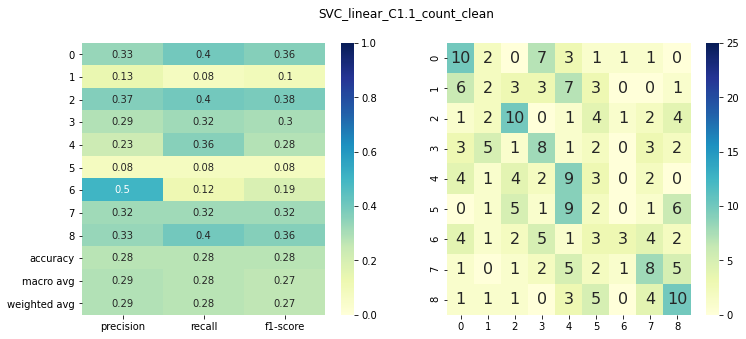

In [163]:
validate_classic_model(
    model_description = "SVC_linear_C1.1_count_clean",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.306732s
Prediction time: 0.056728s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


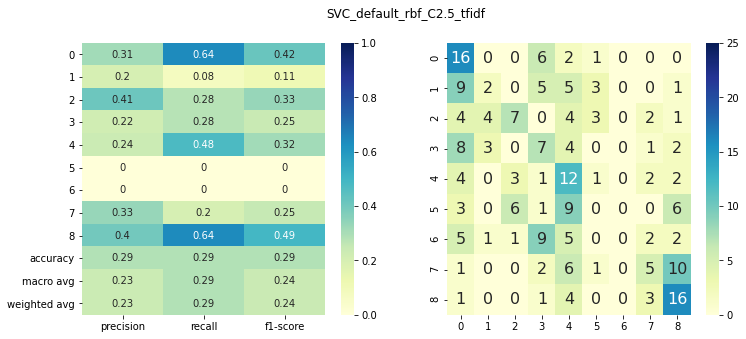

In [164]:
validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_tfidf",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.305993s
Prediction time: 0.053719s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


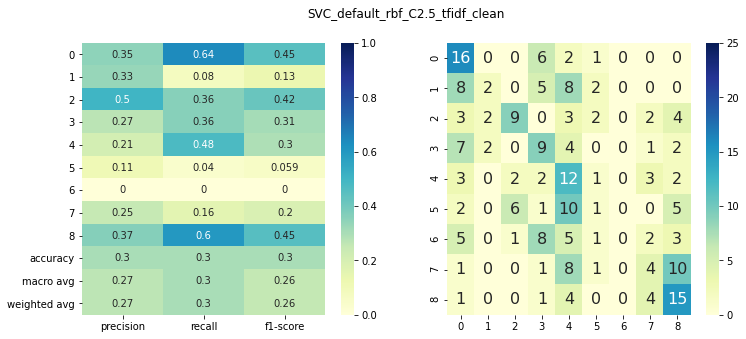

In [165]:
validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_tfidf_clean",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.373246s
Prediction time: 0.063060s


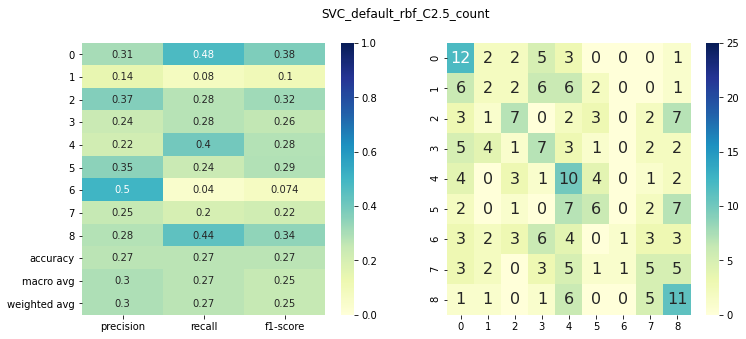

In [166]:
validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_count",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.368840s
Prediction time: 0.063121s


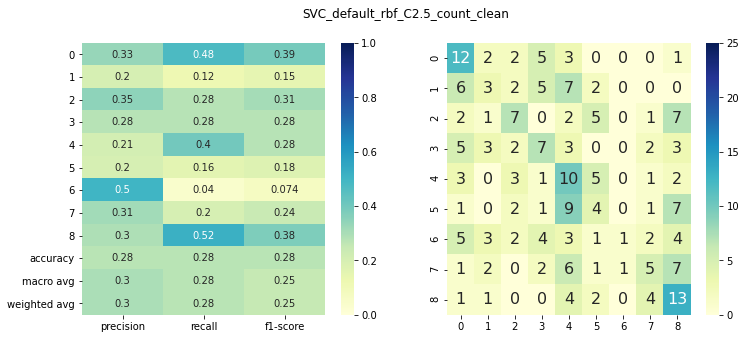

In [167]:
validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_count_clean",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.453810s
Prediction time: 0.102778s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


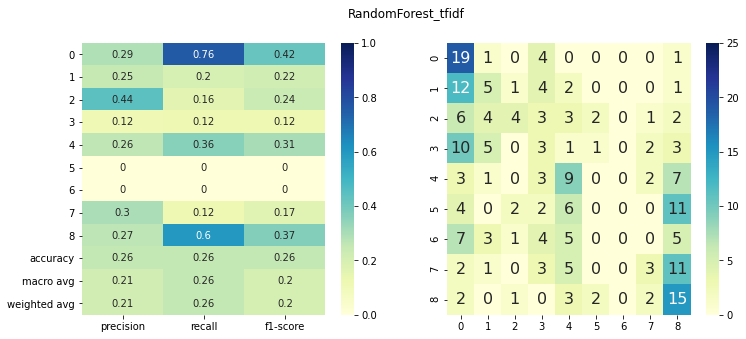

In [168]:
validate_classic_model(
    model_description = "RandomForest_tfidf",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.456421s
Prediction time: 0.102667s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


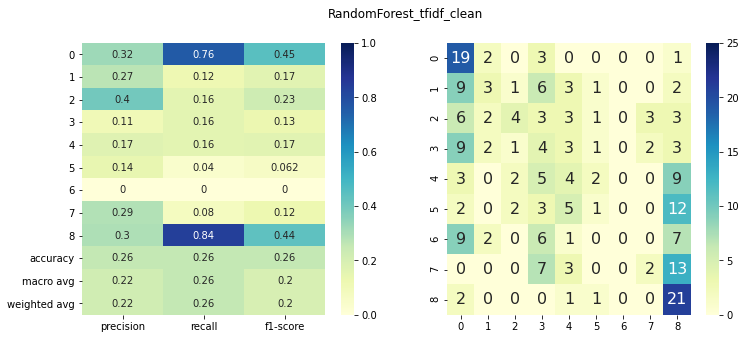

In [169]:
validate_classic_model(
    model_description = "RandomForest_tfidf_clean",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.453294s
Prediction time: 0.102905s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


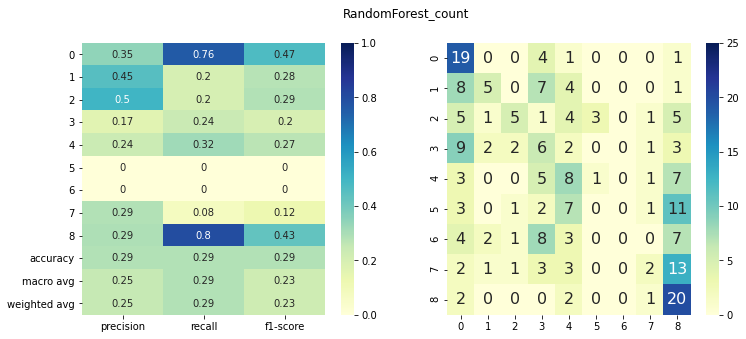

In [170]:
validate_classic_model(
    model_description = "RandomForest_count",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.451223s
Prediction time: 0.102946s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


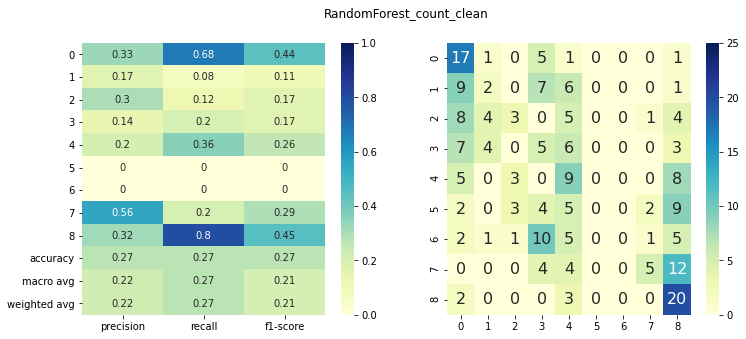

In [171]:
validate_classic_model(
    model_description = "RandomForest_count_clean",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.022990s
Prediction time: 0.000829s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


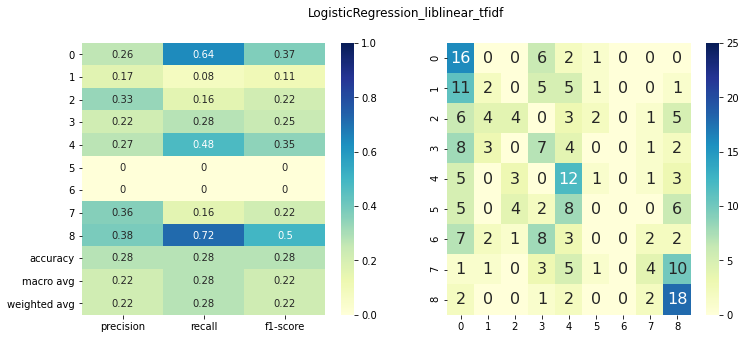

In [172]:
validate_classic_model(
    model_description = "LogisticRegression_liblinear_tfidf",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.026714s
Prediction time: 0.000697s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


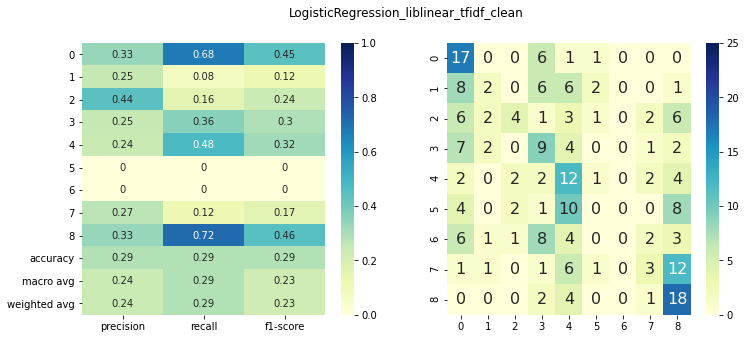

In [173]:
validate_classic_model(
    model_description = "LogisticRegression_liblinear_tfidf_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.065572s
Prediction time: 0.000747s


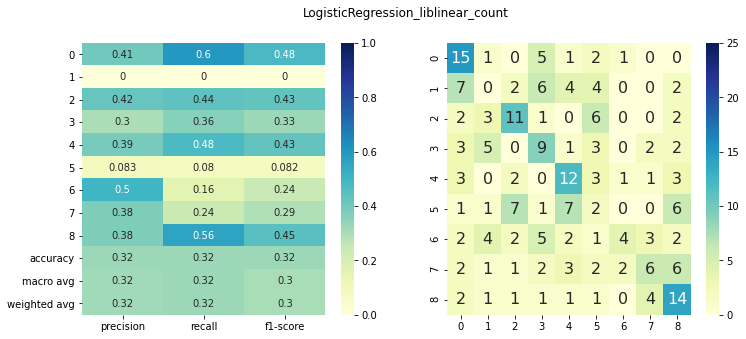

In [174]:
validate_classic_model(
    model_description = "LogisticRegression_liblinear_count",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.061627s
Prediction time: 0.000677s


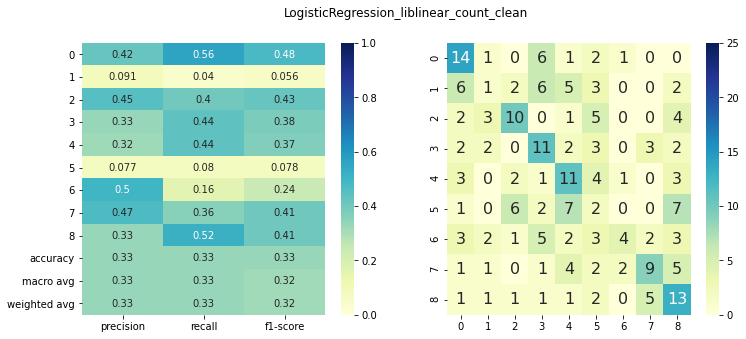

In [175]:
validate_classic_model(
    model_description = "LogisticRegression_liblinear_count_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.096276s
Prediction time: 0.000666s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


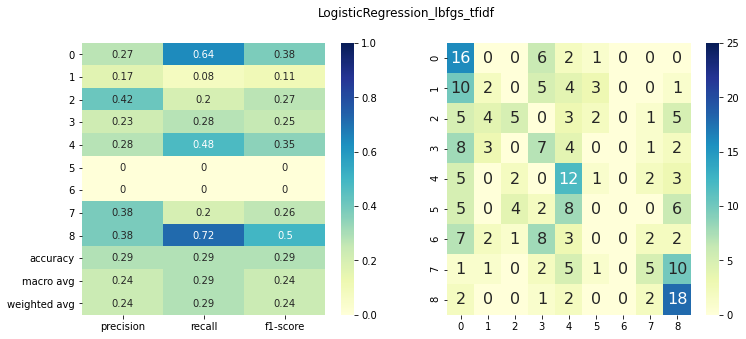

In [176]:
validate_classic_model(
    model_description = "LogisticRegression_lbfgs_tfidf",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs'),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 0.097195s
Prediction time: 0.000653s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


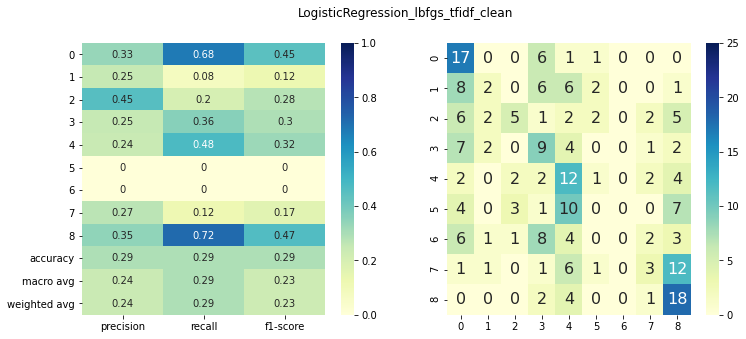

In [177]:
validate_classic_model(
    model_description = "LogisticRegression_lbfgs_tfidf_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs'),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 1.097247s
Prediction time: 0.000501s


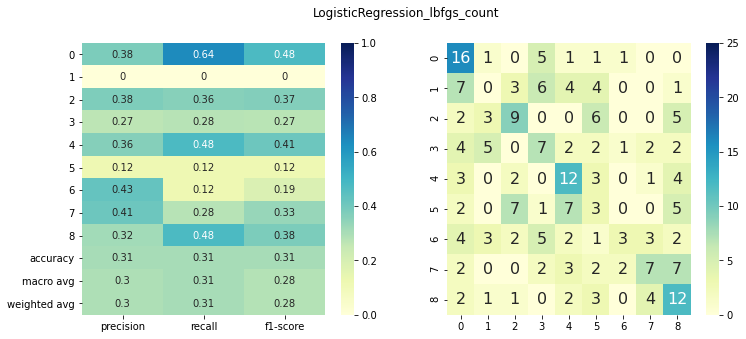

In [178]:
validate_classic_model(
    model_description = "LogisticRegression_lbfgs_count",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=200),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Training time: 1.053098s
Prediction time: 0.000449s


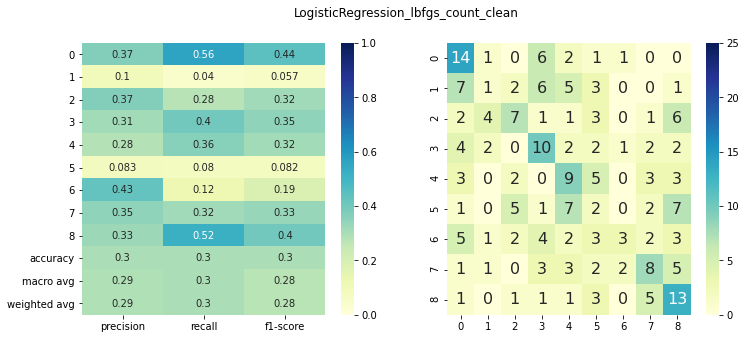

In [179]:
validate_classic_model(
    model_description = "LogisticRegression_lbfgs_count_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=200),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

In [180]:
classic_model_results_df.index += 1 
classic_model_results_df.to_csv(STATS_FOLDER +'/classic_model_results.csv')
classic_model_results_df

,model_configuration,weighted_avg_f1
1,multinomialMB_alpha_.2_tfidf,0.243827
2,multinomialMB_alpha_.2_tfidf_clean,0.255934
3,multinomialMB_alpha_.2_count,0.296700
4,multinomialMB_alpha_.2_count_clean,0.306617
5,SVC_linear_C1.1_tfidf,0.277171
6,SVC_linear_C1.1_tfidf_clean,0.267395
7,SVC_linear_C1.1_count,0.276336
8,SVC_linear_C1.1_count_clean,0.265397
9,SVC_default_rbf_C2.5_tfidf,0.241376
10,SVC_default_rbf_C2.5_tfidf_clean,0.257053


In [181]:
classic_model_results_df.loc[classic_model_results_df['weighted_avg_f1'] == classic_model_results_df['weighted_avg_f1'].max()]

,model_configuration,weighted_avg_f1
20,LogisticRegression_liblinear_count_clean,0.316915
